# Neo4j Demo 2020-10-20
---

This notebook contains the code used at the Neo4J Nodes conference 2020

#### Imports

In [1]:
from py2neo import Graph
import pandas as pd

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import rdDepictor
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole
from IPython.core.display import display, HTML
from rdkit.Chem import MACCSkeys
rdDepictor.SetPreferCoordGen(True)
IPythonConsole.ipython_useSVG = True
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

### 1) Connect to the graph

In [2]:
graph_1 = Graph(host="localhost", password='mmpkg')

In [3]:
graph_1.run("""RETURN gds.version()""").data()

[{'gds.version()': '1.3.0'}]

### 2) Create your in-memory graphs

In [4]:
# This one is needed for compound similarity and fragment->compound degree
graph_1.run("""
            CALL gds.graph.create('fragsimgraph', ['Compound', 'Fragment'], 'IS_FRAGMENT_OF')
            """).data()

[{'nodeProjection': {'Fragment': {'properties': {}, 'label': 'Fragment'},
   'Compound': {'properties': {}, 'label': 'Compound'}},
  'relationshipProjection': {'IS_FRAGMENT_OF': {'orientation': 'NATURAL',
    'aggregation': 'DEFAULT',
    'type': 'IS_FRAGMENT_OF',
    'properties': {}}},
  'graphName': 'fragsimgraph',
  'nodeCount': 5122,
  'relationshipCount': 7551,
  'createMillis': 139}]

In [5]:
# This one we'll use for compound->fragment degree
graph_1.run("""
            CALL gds.graph.create('compound_degree_graph', ['Fragment', 'Compound'], 
            {IS_FRAGMENT_OF: {
                    type: 'IS_FRAGMENT_OF',
                    orientation: 'REVERSE'
            }})
            """).data()

[{'nodeProjection': {'Fragment': {'properties': {}, 'label': 'Fragment'},
   'Compound': {'properties': {}, 'label': 'Compound'}},
  'relationshipProjection': {'IS_FRAGMENT_OF': {'orientation': 'REVERSE',
    'aggregation': 'DEFAULT',
    'type': 'IS_FRAGMENT_OF',
    'properties': {}}},
  'graphName': 'compound_degree_graph',
  'nodeCount': 5122,
  'relationshipCount': 7551,
  'createMillis': 31}]

In [6]:
# Fragment only graph with all edges - we'll use this for pagerank
graph_1.run("""
            CALL gds.graph.create('fraggraph', ['Fragment'],['IS_FRAGMENT_OF','MMP_RULE_ENVIRONMENT'],
            {relationshipProperties:['avg']})
            """).data()

[{'nodeProjection': {'Fragment': {'properties': {}, 'label': 'Fragment'}},
  'relationshipProjection': {'IS_FRAGMENT_OF': {'orientation': 'NATURAL',
    'aggregation': 'DEFAULT',
    'type': 'IS_FRAGMENT_OF',
    'properties': {'avg': {'property': 'avg',
      'aggregation': 'DEFAULT',
      'defaultValue': nan}}},
   'MMP_RULE_ENVIRONMENT': {'orientation': 'NATURAL',
    'aggregation': 'DEFAULT',
    'type': 'MMP_RULE_ENVIRONMENT',
    'properties': {'avg': {'property': 'avg',
      'aggregation': 'DEFAULT',
      'defaultValue': nan}}}},
  'graphName': 'fraggraph',
  'nodeCount': 3598,
  'relationshipCount': 77408,
  'createMillis': 390}]

In [7]:
#Fragment only graph with fragment-fragment edges only - we'll use this to calculate fragment-fragment degree
graph_1.run("""
            CALL gds.graph.create('fraggraph_2', ['Fragment'],
            {MMP_RULE_ENVIRONMENT: {
                        type: 'MMP_RULE_ENVIRONMENT',
                        orientation: 'UNDIRECTED',
                        properties:['avg']}}
                                 )
            """).data()

[{'nodeProjection': {'Fragment': {'properties': {}, 'label': 'Fragment'}},
  'relationshipProjection': {'MMP_RULE_ENVIRONMENT': {'orientation': 'UNDIRECTED',
    'aggregation': 'DEFAULT',
    'type': 'MMP_RULE_ENVIRONMENT',
    'properties': {'avg': {'property': 'avg',
      'aggregation': 'DEFAULT',
      'defaultValue': nan}}}},
  'graphName': 'fraggraph_2',
  'nodeCount': 3598,
  'relationshipCount': 154816,
  'createMillis': 142}]

In [8]:
#View the list of current graphs
pd.DataFrame(graph_1.run("""
            CALL gds.graph.list()
            """).data())

,creationTime,degreeDistribution,graphName,memoryUsage,modificationTime,nodeCount,nodeProjection,nodeQuery,relationshipCount,relationshipProjection,relationshipQuery,schema,sizeInBytes
0,2020-10-09T17:08:38.722712000+01:00,"{'p99': 13, 'min': 0, 'max': 221, 'mean': 1.47...",compound_degree_graph,1708 KiB,2020-10-09T17:08:38.756265000+01:00,5122,"{'Fragment': {'properties': {}, 'label': 'Frag...",None,7551,"{'IS_FRAGMENT_OF': {'orientation': 'REVERSE', ...",None,"{'relationships': {'IS_FRAGMENT_OF': {}}, 'nod...",1749152
1,2020-10-09T17:08:47.605108000+01:00,"{'p99': 228, 'min': 0, 'max': 1958, 'mean': 21...",fraggraph,4337 KiB,2020-10-09T17:08:48.002522000+01:00,3598,"{'Fragment': {'properties': {}, 'label': 'Frag...",None,77408,"{'IS_FRAGMENT_OF': {'orientation': 'NATURAL', ...",None,{'relationships': {'IS_FRAGMENT_OF': {'avg': '...,4442088
2,2020-10-09T17:08:04.358976000+01:00,"{'p99': 17, 'min': 0, 'max': 36, 'mean': 1.474...",fragsimgraph,1708 KiB,2020-10-09T17:08:06.184282000+01:00,5122,"{'Fragment': {'properties': {}, 'label': 'Frag...",None,7551,"{'IS_FRAGMENT_OF': {'orientation': 'NATURAL', ...",None,"{'relationships': {'IS_FRAGMENT_OF': {}}, 'nod...",1749152
3,2020-10-09T17:09:25.036845000+01:00,"{'p99': 354, 'min': 0, 'max': 2372, 'mean': 43...",fraggraph_2,2735 KiB,2020-10-09T17:09:25.180051000+01:00,3598,"{'Fragment': {'properties': {}, 'label': 'Frag...",None,154816,{'MMP_RULE_ENVIRONMENT': {'orientation': 'UNDI...,None,{'relationships': {'MMP_RULE_ENVIRONMENT': {'a...,2801632


In [13]:
#Delete a graph
pd.DataFrame(graph_1.run("""
            CALL gds.graph.drop('fragsimgraph_test') YIELD graphName;
            """).data())

,graphName
0,fragsimgraph_test


### 3a) Node Similarity
##### Find me compounds that are similar to each other by fragments

In [9]:
#Fetch data
node_sim_data = graph_1.run("""
            CALL gds.nodeSimilarity.stream('fragsimgraph')
            YIELD node1, node2, similarity
            RETURN gds.util.asNode(node1).smiles AS Compound1, 
                   gds.util.asNode(node2).smiles AS Compound2, 
                   gds.util.asNode(node1).compoundid as Compound_id1,
                   gds.util.asNode(node2).compoundid as Compound_id2,
                   similarity
            ORDER BY similarity DESCENDING, Compound1, Compound2
            """).data()
#Convert to pandas
node_sim_df = pd.DataFrame(node_sim_data)
#Add RDKIT molecules
PandasTools.AddMoleculeColumnToFrame(node_sim_df, 'Compound1','Compound1')
PandasTools.AddMoleculeColumnToFrame(node_sim_df, 'Compound2','Compound2')

,Compound1,Compound2,Compound_id1,Compound_id2,similarity
0,,,1459,1495,1.0
1,,,1495,1459,1.0
2,,,1357,1331,1.0
3,,,1357,1321,1.0
4,,,1357,1354,1.0

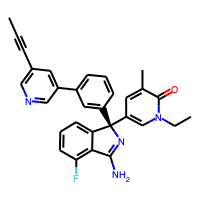
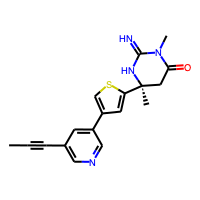
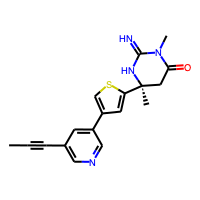
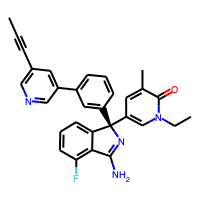
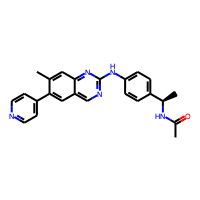
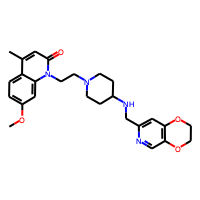
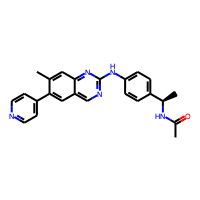
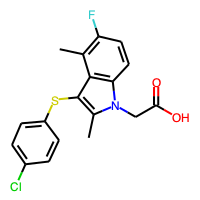
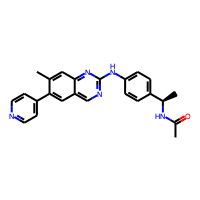
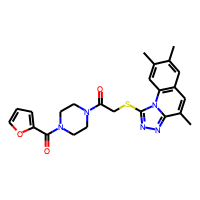

In [10]:
node_sim_df.head()

In [11]:
#Write
graph_1.run("""
            CALL gds.nodeSimilarity.write('fragsimgraph',
                {
                writeRelationshipType: 'SIMILAR_BY_FRAGMENT',
                writeProperty: 'similarity_score'
                })
                YIELD nodesCompared, relationshipsWritten
                """).data()

[{'nodesCompared': 1524, 'relationshipsWritten': 10149}]

### 3b) Degree - Number of fragments per compound node

In [12]:
# Number of nodes per fragment node
data = graph_1.run("""
                CALL gds.alpha.degree.write('fragsimgraph',{writeProperty: 'fragment_degree'})
                YIELD nodes, writeProperty
                """).data()

In [13]:
# Number of fragments per compound node
data = graph_1.run("""
                CALL gds.alpha.degree.write('compound_degree_graph',{writeProperty: 'compound_degree'})
                YIELD nodes, writeProperty
                """).data()

In [14]:
# Number of fragments per fragment node
data = graph_1.run("""
                CALL gds.alpha.degree.write('fraggraph_2',{writeProperty: 'frag_frag_degree'})
                YIELD nodes, writeProperty
                """).data()

### 3c) Let's compare to other similarity metrics

In [15]:
#Fetch data
node_sim_data = graph_1.run("""MATCH (n:Compound)-[m]-(p)
                               WHERE n.fragment_degree>=15
                               AND m.similarity_score IS NOT null
                               AND startnode(m) = n
                               RETURN
                               DISTINCT n.compoundid AS cid1, 
                                        n.smiles AS Compound1, 
                                        n.fragment_degree,
                                        p.compoundid AS cid2,
                                        p.smiles AS Compound2,
                                        p.fragment_degree,
                                        m.similarity_score
                              ORDER BY m.similarity_score DESC""").data()
#Convert to pandas
node_sim_df = pd.DataFrame(node_sim_data)

In [16]:
#Add RDKIT molecules
PandasTools.AddMoleculeColumnToFrame(node_sim_df, 'Compound1','Compound1')
PandasTools.AddMoleculeColumnToFrame(node_sim_df, 'Compound2','Compound2')
#Calculate Morgan fingerprints for comparison
fps_c1 = [AllChem.GetMorganFingerprintAsBitVect(x,radius=2, nBits=1024) for x in node_sim_df['Compound1']]
fps_c2 = [AllChem.GetMorganFingerprintAsBitVect(x,radius=2, nBits=1024) for x in node_sim_df['Compound2']]
node_sim_df['morgan_1024_r2_sim'] = [DataStructs.FingerprintSimilarity(x, y, metric=DataStructs.TanimotoSimilarity) for x, y in zip(fps_c1, fps_c2)]
#Calculate MACCS fingerprint similarity for comparison
maccs1 = [MACCSkeys.GenMACCSKeys(x) for x in node_sim_df['Compound1'].tolist()]
maccs2 = [MACCSkeys.GenMACCSKeys(x) for x in node_sim_df['Compound2'].tolist()]
node_sim_df['maccs_sim'] = [DataStructs.FingerprintSimilarity(x, y, metric=DataStructs.TanimotoSimilarity) for x, y in zip(maccs1, maccs2)]

,Compound1,Compound2,cid1,cid2,m.similarity_score,n.fragment_degree,p.fragment_degree,morgan_1024_r2_sim,maccs_sim
0,,,544,548,1.000000,17.0,17.0,0.505263,0.887324
3,,,549,547,1.000000,15.0,15.0,0.697674,0.971831
1,,,547,549,1.000000,15.0,15.0,0.697674,0.971831
2,,,548,544,1.000000,17.0,17.0,0.505263,0.887324
6,,,546,544,0.941176,16.0,17.0,0.698795,0.914286
7,,,548,546,0.941176,17.0,16.0,0.697674,0.971831
4,,,544,546,0.941176,17.0,16.0,0.698795,0.914286
5,,,546,548,0.941176,16.0,17.0,0.697674,0.971831
9,,,557,555,0.894737,18.0,18.0,0.637931,0.821429
8,,,555,557,0.894737,18.0,18.0,0.637931,0.821429

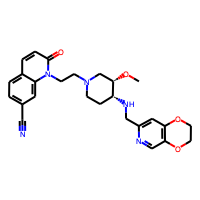
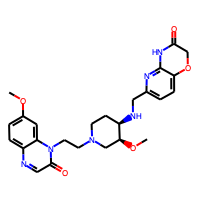
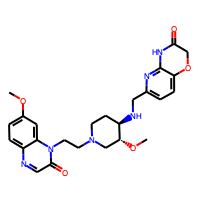
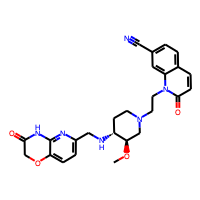
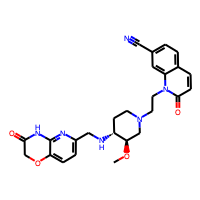
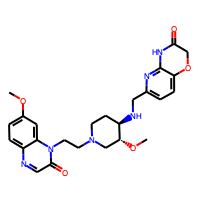
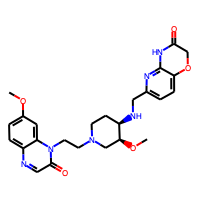
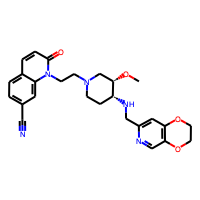
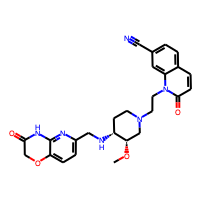
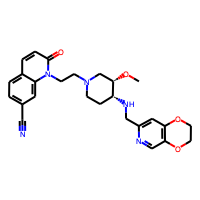
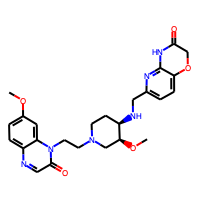
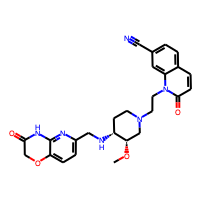
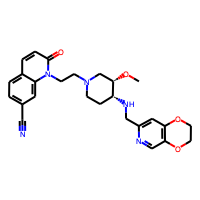
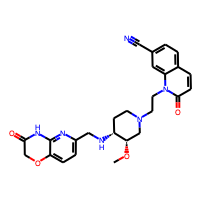
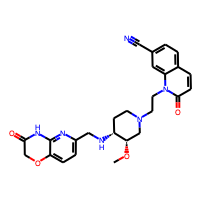
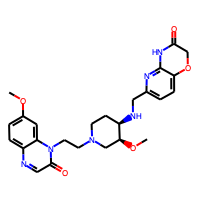
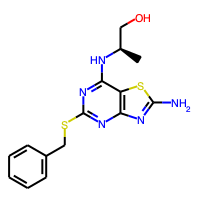
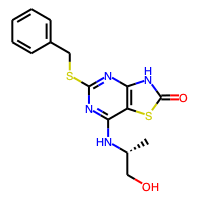
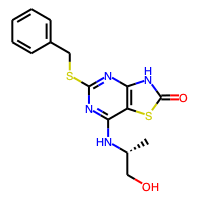
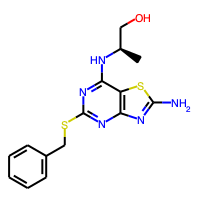

In [17]:
node_sim_df.sort_values(by=['m.similarity_score'], ascending=False).head(10)

### 4a) Pagerank
##### Find me fragments which are important, based on their place in the fragment network, weighted by avg MMP change - maybe these are the ones that get changed the most frequently?

In [15]:
pagerank_w = graph_1.run("""
                CALL gds.pageRank.write('fraggraph', {relationshipWeightProperty:'avg', writeProperty:'fragment_pageRank'})
                """).data()

In [16]:
pagerank_uw = graph_1.run("""
                CALL gds.pageRank.write('fraggraph', {writeProperty:'fragment_pageRank_unweighted'})
                """).data()

In [17]:
page_data = graph_1.run("""
                MATCH (n:Fragment)
                WHERE EXISTS(n.fragment_pageRank)
                RETURN n.smiles as smiles, n.fragment_pageRank as fragment_pageRank, n.fragment_pageRank_unweighted, n.compound_degree, n.frag_frag_degree,
                       n.unique_fragment_count
                ORDER by n.fragment_pageRank DESC
                """).data()

In [18]:
#Convert to pandas
page_df = pd.DataFrame(page_data)
#Add RDKIT molecules
PandasTools.AddMoleculeColumnToFrame(page_df, 'smiles','Fragment')

,fragment_pageRank,n.compound_degree,n.frag_frag_degree,n.fragment_pageRank_unweighted,n.unique_fragment_count,smiles,Fragment
0,4.979573,221.0,2372.0,11.085179,None,[*:1][H],
1,3.609844,68.0,1749.0,4.971513,None,[*:1]c1ccccc1,
2,3.092455,26.0,613.0,3.544064,None,[*:1]c1ccccc1[*:2],
3,2.978492,1.0,24.0,1.230628,None,[*:1]c1ccccc1N([*:2])C,
4,2.911339,1.0,114.0,0.766771,None,[*:1]c1ccccc1N(C)C,

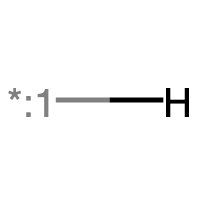
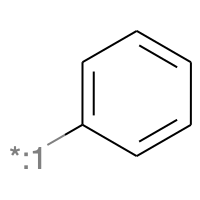
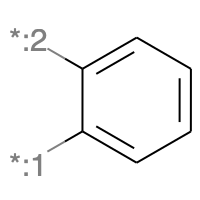
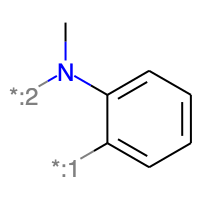
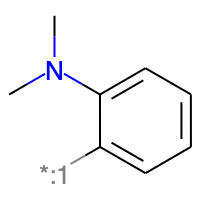

In [19]:
page_df.head()

### 5) Link prediction

* It's not useful to predict links between compounds here... i.e. which compounds will be MMP of each other... compounds are either MMP or they are not...

* Instead what is more useful is to predict whether FRAGMENTS will be related (i.e. will changing one fragment for another change a property I am interested in?)

##### We can use Adamic Adar for this
* Adamic Adar is a measure used to compute the closeness of nodes based on their shared neighbors.
* This will tell us the likelyhood of a relationship between two fragments - "if you have this in your molecule have you tried this?"
* What it does not tell us is the size of that property or even what property... to do this we'll need more advanced algos that can account for more features of nodes and relationships.

In [23]:
#Fetch data
aa_data = graph_1.run("""MATCH (f1:Fragment), (f2:Fragment)
                               WHERE NOT (f1)-[:MMP_RULE_ENVIRONMENT]-(f2)
                               AND f1.compound_degree > 10
                               AND f2.compound_degree > 10
                               RETURN gds.alpha.linkprediction.adamicAdar(f1, f2) AS score, 
                                      f1.smiles, 
                                      f2.smiles, 
                                      f1.compound_degree
                               ORDER BY score DESC""").data()
#Convert to pandas
aa_df = pd.DataFrame(aa_data)
#Add RDKIT molecules
PandasTools.AddMoleculeColumnToFrame(aa_df, 'f1.smiles','Fragment1')
PandasTools.AddMoleculeColumnToFrame(aa_df, 'f2.smiles','Fragment2')

,f1.compound_degree,f1.smiles,f2.smiles,score,Fragment1,Fragment2
0,29.0,[*:1]C([*:2])C,[*:1]C,6.190237,,
1,192.0,[*:1]C,[*:1]C([*:2])C,6.190237,,
2,70.0,[*:1]OC,[*:1]O[*:2],5.591355,,
3,33.0,[*:1]O[*:2],[*:1]OC,5.591355,,
4,84.0,[*:1]F,[*:1]c1ccc(F)cc1,5.520216,,
5,18.0,[*:1]c1ccc(F)cc1,[*:1]F,5.520216,,
6,45.0,[*:1]CC,[*:1]OCC,5.192471,,
7,18.0,[*:1]OCC,[*:1]CC,5.192471,,
8,41.0,[*:1]c1ccc([*:2])cc1,[*:1][H],4.082251,,
9,221.0,[*:1][H],[*:1]c1ccc([*:2])cc1,4.082251,,

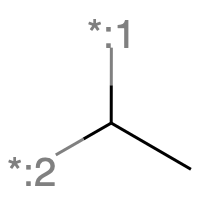
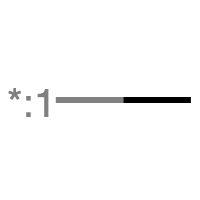
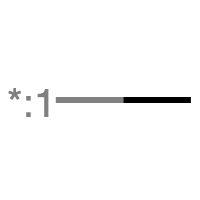
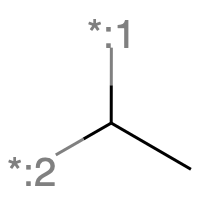
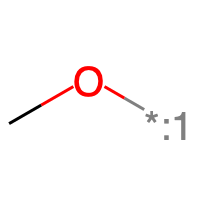
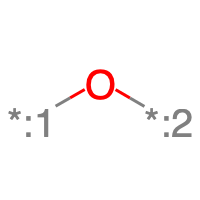
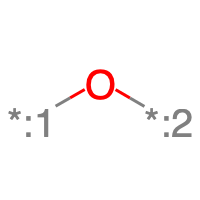
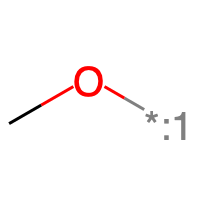
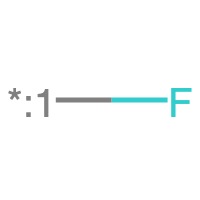
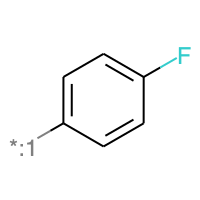
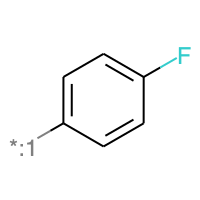
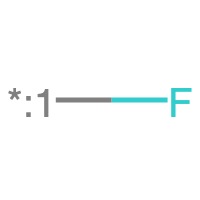
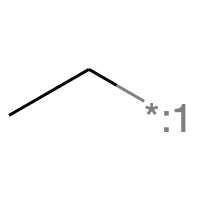
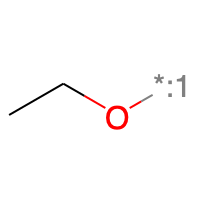
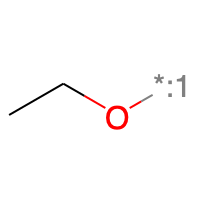
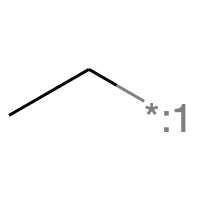
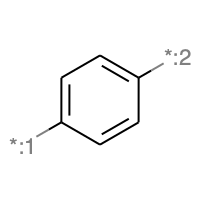
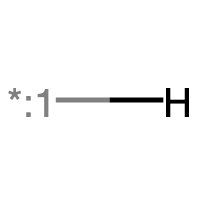
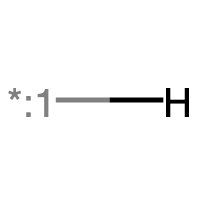
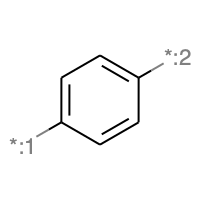
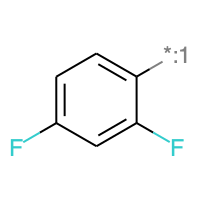
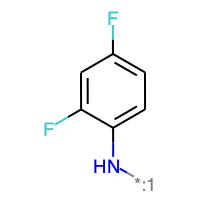
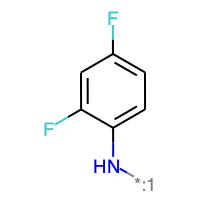
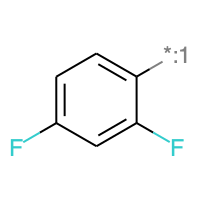
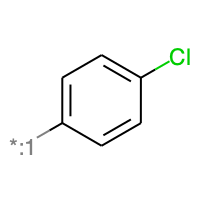
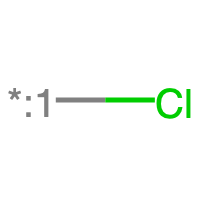
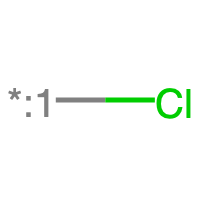
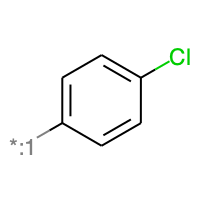
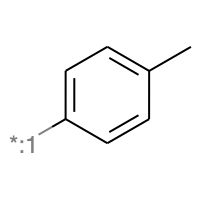
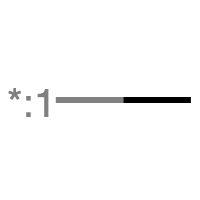
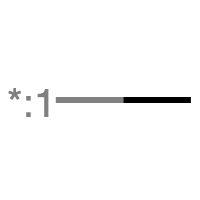
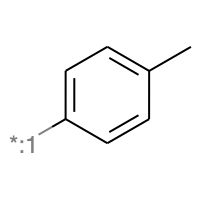
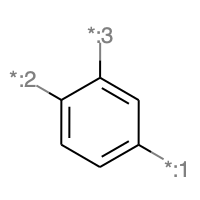
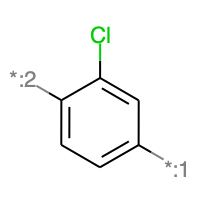
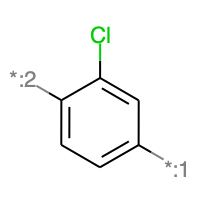
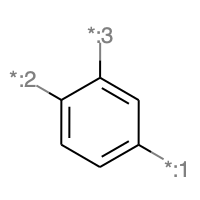
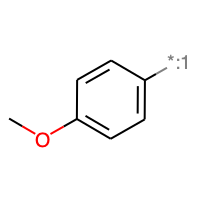
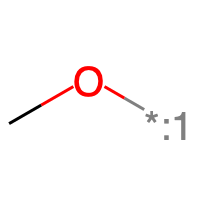
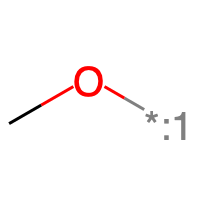
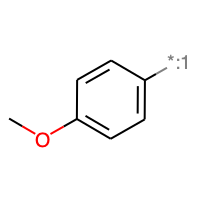

In [24]:
aa_df.head(20)

### BONUS) Plotting

In [20]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource
from bokeh.models.tools import HoverTool
from sklearn.linear_model import LinearRegression
from bokeh.models import Slope
output_notebook()

Loading BokehJS ...

In [131]:
node_sim_df2 = node_sim_df[['m.similarity_score','maccs_sim','cid1','cid2']]

In [133]:
p = figure()
p.circle(x='m.similarity_score', y='maccs_sim',
         source=node_sim_df2,
         size=5, color='blue')
p.xaxis.axis_label = "node similarity"
p.yaxis.axis_label = "maccs similarity"
hover = HoverTool()
hover.tooltips=[
    ('molecule1', '@cid1'),
    ('molecule2', '@cid2'),
    ('node_sim','@m.similarity_score'),
    ('maccs_sim','@maccs_sim'),
#    ('fragment_pageRank', '@fragment_pageRank')
]

p.add_tools(hover)

show(p)